This notebook is adapted for running on Google Colab. Please notice some paths and file imports might NOT be adapted for running immmediately.

In [ ]:
from config import *

# 0. Google Drive prep

In [ ]:
#--- Google Drive mount ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
#--- Sorting all the fMRI files into dictionary ---
all_files = sorted(glob.glob(
    "drive/MyDrive/fmriprep/bids_root/sub-*/func/sub-*_task-movie_run-*_bold.nii.gz"
))

def extract_subject_id(path):
    match = re.search(r"sub-(\d+)", path)
    return match.group(1) if match else None

subject_runs = defaultdict(list)

for path in all_files:
    subject_id = extract_subject_id(path)
    if subject_id:
        subject_runs[subject_id].append(path)

In [ ]:
#--- Importing the meta data ---
meta_path = 'drive/MyDrive/fmriprep/Xmetadata.pkl'

with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

validx_path = 'drive/MyDrive/fmriprep/valindices.pkl'
with open(validx_path, 'rb') as f:
    val_idx = pickle.load(f)

meta_val = [meta[i] for i in val_idx]

# 1. Pretraining

In [ ]:
#--- Initializing model with the best weights ---
model = model = Bigger3DCNN(in_channels=1, num_classes=5, dropout_p=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights_path = "/content/drive/MyDrive/fmriprep/newbestmodel.pth"
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

print("Model loaded from", weights_path)

In [ ]:
#--- Preparing the labels mapping ---
unique_labels = sorted({ entry['label'] for entry in meta_val })
label_to_int  = { lab:i for i, lab in enumerate(unique_labels) }
inv_label_map = { i:lab for lab,i in label_to_int.items() }

In [ ]:
# --- Sample calculating all the output probabilities for a random sample ---

# Index of the sample you want to test
indx = 80  
entry = meta_val[indx]

subj    = entry['subject']
run     = entry['run_idx']
tr      = entry['TR_local']
affine  = entry['affine']
filepath = f"drive/MyDrive/fmriprep/bids_root/sub-{subj}/func/sub-{subj}_task-movie_run-{run}_bold.nii.gz"

# Loading the NIfTI files and converting into numpy arrays
img4d   = nib.load(filepath)       
data4d  = img4d.get_fdata()                  # shape (X_full, Y_full, Z_full, T)
vol3d   = data4d[..., entry['TR_local']]     # shape (X_full, Y_full, Z_full)
affine  = entry['affine']

# Normalizing the volume
mu, sigma = vol3d.mean(), vol3d.std()
vol_norm = (vol3d - mu) / (sigma + 1e-6)

# Resizing the volume to the model's input size
x_in = torch.from_numpy(vol_norm).float().unsqueeze(0).unsqueeze(0).to(device)

# Running a forward pass
model = model.to(device)
model.eval()
with torch.no_grad():
    logits = model(x_in)            # shape = (1, num_classes)
    probs  = F.softmax(logits, dim=1).cpu().numpy()[0]  # (num_classes,)

# Printing the results
print(f"Probabilities for sample #{i} (true = {entry['label']!r}):")
for idx, p in enumerate(probs):
    print(f"  {inv_label_map[idx]:<12s}: {p:.3f}")

Probabilities for sample #80 (true = 'SADNESS'):
  ANGERRAGE   : 0.000
  FEAR        : 0.000
  HAPPINESS   : 0.165
  LOVE        : 0.000
  SADNESS     : 0.835


In [ ]:
#--- Loading in OR rebuilding the filtered metadata ---
# Filtered metadata, in this case, implies all the validation samples in which the confidence in
# the true label was greater than the threshold value.

try:
  out_path = '/content/drive/MyDrive/fmriprep/meta_val_filtered.pkl'

  with open(out_path, 'rb') as f:
      meta_kept = pickle.load(f)
  print(f"Loaded {len(meta_kept)} samples from {out_path}.")
except FileNotFoundError:

  # Config
  threshold = 0.75
  meta_kept = []

  # Running forward passes
  model.eval()
  for entry in tqdm(meta_val, desc="Filtering val set"):

    subj    = entry['subject']
    run     = entry['run_idx']
    tr      = entry['TR_local']
    affine  = entry['affine']
    filepath = f"drive/MyDrive/fmriprep/bids_root/sub-{subj}/func/sub-{subj}_task-movie_run-{run}_bold.nii.gz"

    img4d  = nib.load(filepath)
    vol3d  = img4d.get_fdata()[..., entry['TR_local']]
    mu, sigma = vol3d.mean(), vol3d.std()
    vol_norm   = (vol3d - mu) / (sigma + 1e-6)
    x_in = (torch.from_numpy(vol_norm)
            .float()
            .unsqueeze(0).unsqueeze(0)
            .to(device))

    with torch.no_grad():
        logits = model(x_in)
        probs  = F.softmax(logits, dim=1)[0]  # shape = (num_classes,)

    pred_idx = int(probs.argmax().item())           # index of the predicted class
    pred_lab = inv_label_map[pred_idx]              # predicted label
    pred_p   = float(probs[pred_idx].cpu().item())  # probability of the predicted class

    if (pred_lab == entry['label']) and (pred_p >= threshold):
        new_entry = entry.copy()
        new_entry['pred_prob'] = pred_p
        meta_kept.append(new_entry)

  out_path = 'meta_val_filtered.pkl'
  with open(out_path, 'wb') as f:
      pickle.dump(meta_kept, f)

  print(f"Kept {len(meta_kept)} / {len(meta_val)} samples (prob ≥ {threshold} & correct).")

Loaded 629 samples from /content/drive/MyDrive/fmriprep/meta_val_filtered.pkl.


# 2. Occlusions

In [ ]:
#--- Setting up a helper function for occlusions ---

def compute_occlusion_map_batched(entry, model, true_label,
                                  device='cuda',
                                  batch_size=256):
    """
    Compute occlusion map for a single sample using batches.
    The occlusion map is computed by occluding each 2x2x2 patch in the
    3D volume and measuring the change in model output.

    Inputs:
        entry: dict containing the sample metadata
        model: the neural network model
        true_label: the true label of the sample
        device: the device to run the model on (default: 'cuda') [GOOGLE COLAB!]
    Outputs:
        occl_map: numpy array of shape (X-1, Y-1, Z-1) containing the occlusion map
    """

    # Loading the volume
    subj = entry['subject']
    run  = entry['run_idx']
    filepath = f"drive/MyDrive/fmriprep/bids_root/sub-{subj}/func/sub-{subj}_task-movie_run-{run}_bold.nii.gz"
    img     = nib.load(filepath)
    vol3d   = img.get_fdata()[..., entry['TR_local']]
    X, Y, Z = vol3d.shape

    # Normalizing
    vol_norm = (vol3d - vol3d.mean())/ (vol3d.std()+1e-6)
    x_orig   = torch.from_numpy(vol_norm[None,None]).float()  # (1,1,X,Y,Z)
    x_orig   = x_orig.to(device)

    # Moving to CUDA
    model = model.to(device).eval()
    with torch.no_grad():
        p0 = F.softmax(model(x_orig), dim=1)[0, true_label].item()

    # Precomputing occlusion positions
    positions = [
        (i, j, k)
        for i in range(X-1)
        for j in range(Y-1)
        for k in range(Z-1)
    ]
    occl_map = np.zeros((X-1, Y-1, Z-1), dtype=np.float32)

    # Batchwise processing
    for start in tqdm(range(0, len(positions), batch_size)):
        batch_pos = positions[start:start+batch_size]
        B = len(batch_pos)
        x_batch = x_orig.repeat(B, 1, 1, 1, 1)  # (B,1,X,Y,Z)

        # Occluding the 2x2x2 patches
        for b, (i,j,k) in enumerate(batch_pos):
            x_batch[b, :, i:i+2, j:j+2, k:k+2] = 0

        # Running the model
        with torch.no_grad():
            logits = model(x_batch)             # (B, num_classes)
            probs  = F.softmax(logits, dim=1)[:, true_label]  # (B,)

        drops = (p0 - probs).cpu().numpy()      # (B,)

        # Storing the results
        for (i,j,k), d in zip(batch_pos, drops):
            occl_map[i, j, k] = d

    return occl_map


In [ ]:
#--- Loading in the model ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = Bigger3DCNN(in_channels=1, num_classes=5).to(device)
model.load_state_dict(
    torch.load('/content/drive/MyDrive/fmriprep/bestmodel.pth',
               map_location=device)
)
model.eval()

In [ ]:
#--- Runing occlusions on 10 random samples per label ---

# Reproducability config
random.seed(42)

# Building the index-label mappings
unique_labels = sorted({ entry['label'] for entry in meta_kept })
label_to_int  = { lab:i for i, lab in enumerate(unique_labels) }
inv_label_map = { i:lab for lab,i in label_to_int.items() }

# Collecting entries by label
entries_by_label = {lbl: [] for lbl in inv_label_map.values()}
for e in meta_kept:
    entries_by_label[e['label']].append(e)

# Computing occlusion maps
mean_maps = {}
for lbl, all_entries in entries_by_label.items():
    print(f"Processing label {lbl!r}…")
    sample_entries = random.sample(all_entries, 10)
    maps10 = []
    for e in tqdm(sample_entries, desc=f"  {lbl}", leave=False):
        idx = label_to_int[lbl]
        occl = occlusion_stride2(e, model, idx, device=device, max_bs=128)
        maps10.append(occl)

    stack10    = np.stack(maps10, axis=0)   # shape (10, dx, dy, dz)
    mean_map   = stack10.mean(axis=0)       # shape (dx, dy, dz)
    mean_maps[lbl] = mean_map


for lbl, m in mean_maps.items():
    print(f"{lbl:10s}: {m.shape}")


Processing label 'ANGERRAGE'…


  ANGERRAGE:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-16-4172aeba7c21>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
<ipython-input-16-4172aeba7c21>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Processing label 'FEAR'…


Processing label 'HAPPINESS'…


  HAPPINESS:  70%|███████   | 7/10 [10:59<04:42, 94.25s/it]

OOM → retry with batch_size=64


  HAPPINESS:  90%|█████████ | 9/10 [13:53<01:31, 91.01s/it]

OOM → retry with batch_size=64


Processing label 'LOVE'…


Processing label 'SADNESS'…


  SADNESS:  80%|████████  | 8/10 [12:25<03:06, 93.01s/it]

OOM → retry with batch_size=64


ANGERRAGE : (40, 40, 17)
FEAR      : (40, 40, 17)
HAPPINESS : (40, 40, 17)
LOVE      : (40, 40, 17)
SADNESS   : (40, 40, 17)


In [ ]:
#--- Saving the occlusion maps ---

import numpy as np
occlusion_maps_path = '/content/drive/MyDrive/fmriprep/occlusion_maps.npy'
np.save(occlusion_maps_path, mean_maps)
print(f"Occlusion map saved to {occlusion_maps_path}")


Occlusion map saved to /content/drive/MyDrive/fmriprep/occlusion_maps.npy


# 3. Data analysis

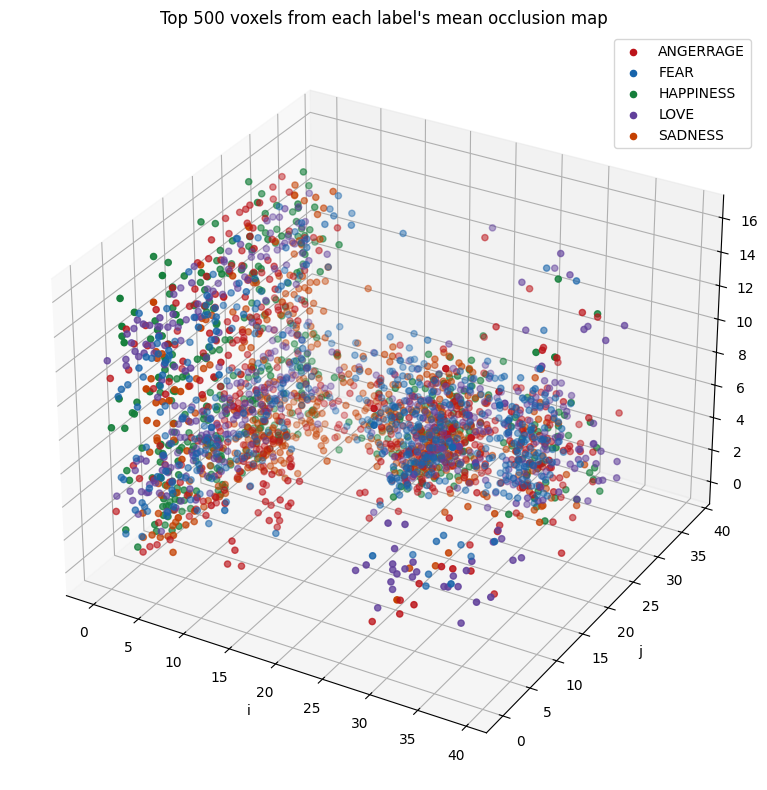

In [ ]:
#--- Plotting the occlusion maps in 3D ---

def scatter_topk_means(mean_maps, K=500, jitter=0.2, figsize=(8,8)):
    """
    Plots top K voxels from each mean occlusion map in distinct colors with legend.

    Inputs:
        mean_maps: dict of mean occlusion maps
        K: number of top voxels to plot from each map
        jitter: amount of random jitter to add to the coordinates
        figsize: size of the figure
    Outputs:
        A 3D scatter plot of the top K voxels from each mean occlusion map
    """

    labels = list(mean_maps.keys())
    N = len(labels)
    cmap_names = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges']
    colors = [plt.get_cmap(cn)(0.8) for cn in cmap_names[:N]]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    for lbl, color in zip(labels, colors):
        data = mean_maps[lbl]
        flat_idx = np.argsort(data.ravel())[::-1][:K]
        coords = np.array(np.unravel_index(flat_idx, data.shape)).T
        coords_j = coords + np.random.uniform(-jitter, jitter, coords.shape)
        ax.scatter(coords_j[:,0], coords_j[:,1], coords_j[:,2],
                   c=[color], s=20, depthshade=True, label=lbl)

    ax.set_xlabel('i')
    ax.set_ylabel('j')
    ax.set_zlabel('k')
    ax.set_title(f"Top {K} voxels from each label's mean occlusion map")
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Running the plotting function
scatter_topk_means(mean_maps, K=500)


Explained variance ratios (PC1, PC2): [0.66045803 0.27843005]


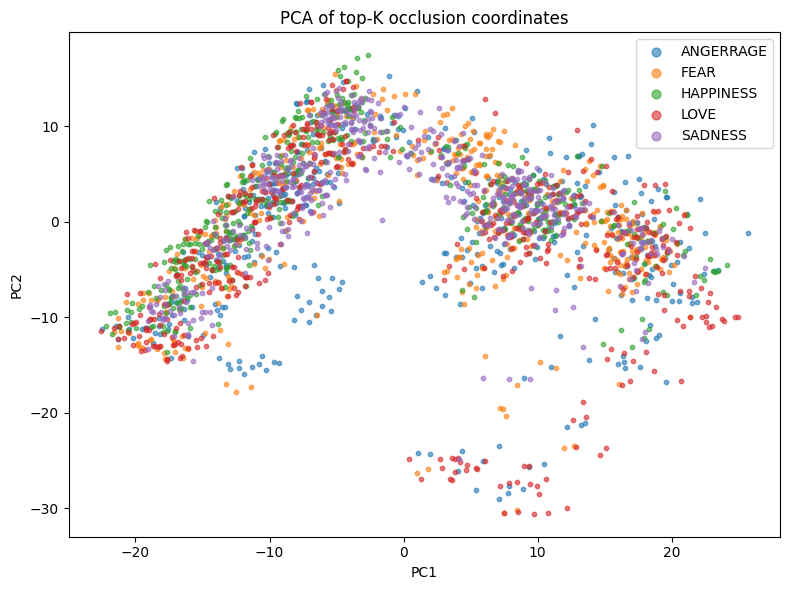

In [ ]:
#--- PCA on the occlusion maps ---

# Config
K = 500     # number of top voxels to plot
labels    = list(mean_maps.keys())
all_coords = []
all_labels = []

# Collecting the top K voxels
for lbl in labels:
    data    = mean_maps[lbl]
    flat_idx= np.argsort(data.ravel())[::-1][:K]
    coords  = np.array(np.unravel_index(flat_idx, data.shape)).T
    coords  = coords + np.random.uniform(-0.2, 0.2, coords.shape)
    all_coords.append(coords)
    all_labels += [lbl]*coords.shape[0]

# Concatenating all coordinates and labels
all_coords = np.vstack(all_coords)   # shape (5*K, 3)
all_labels = np.array(all_labels)    # shape (5*K,)

# Running the PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(all_coords)  # shape (5*K, 2)

print("Explained variance ratios (PC1, PC2):", pca.explained_variance_ratio_)

# Plotting the PCA results
plt.figure(figsize=(8,6))
for lbl in labels:
    mask = (all_labels == lbl)
    plt.scatter(proj[mask, 0], proj[mask, 1],
                label=lbl, s=10, alpha=0.6)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of top-K occlusion coordinates')
plt.legend(markerscale=2)
plt.tight_layout()
plt.show()

all_coords.shape: (2500, 3)
all_labels counts: (array([0, 1, 2, 3, 4]), array([500, 500, 500, 500, 500]))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding ranges: [-8.278243  -0.7763122] [14.016839 17.756104]


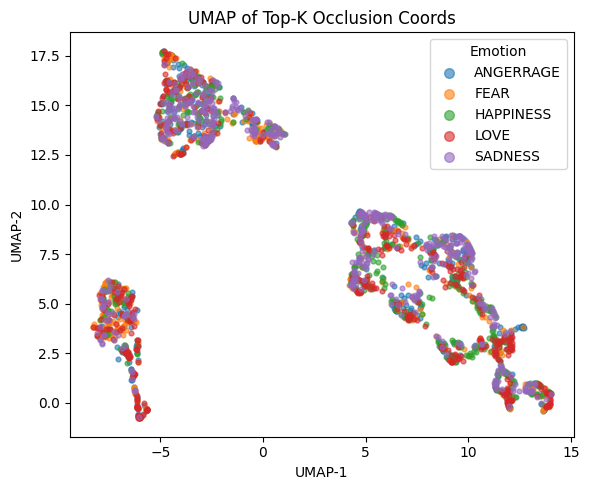

In [ ]:
#--- Spatial UMAP ---

# Config
K = 500
coords_list = []
labels_list = []

# Collecting the top K voxels
for name, volume in mean_maps.items():
    lbl = label_to_int[name]
    flat = np.argsort(volume.ravel())[::-1][:K]
    coords = np.vstack(np.unravel_index(flat, volume.shape)).T
    coords_list.append(coords)
    labels_list += [lbl] * coords.shape[0]

# for each mean occlusion map
all_coords = np.vstack(coords_list)    # shape (5*K, 3)
all_labels = np.array(labels_list)     # shape (5*K,)

print("all_coords.shape:", all_coords.shape)
print("all_labels counts:", np.unique(all_labels, return_counts=True))

# Running UMAP
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric='euclidean',
    random_state=0,
)
embedding = reducer.fit_transform(all_coords)
print("UMAP embedding ranges:", embedding.min(axis=0), embedding.max(axis=0))

# Plotting the UMAP results
plt.figure(figsize=(6,5))
for lbl, color in zip(range(5), ['C0','C1','C2','C3','C4']):
    mask = (all_labels == lbl)
    plt.scatter(embedding[mask,0], embedding[mask,1],
                s=12, alpha=0.6, c=color,
                label=inv_label_map[lbl])
plt.legend(title="Emotion", markerscale=2)
plt.title("UMAP of Top-K Occlusion Coords")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


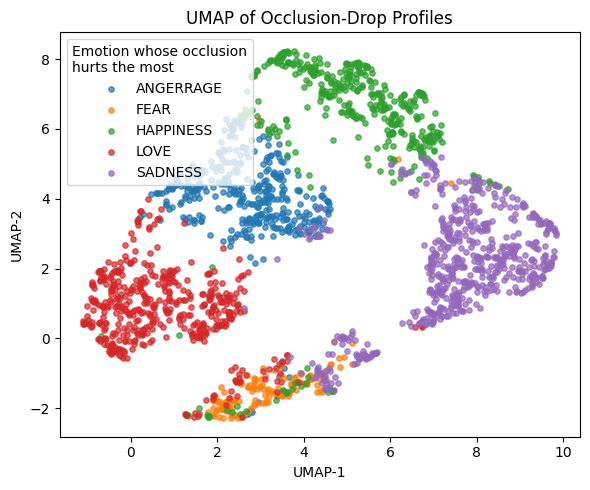

In [ ]:
#--- Functional UMAP ---

# Config
K = 500
coord_set = set()
emotions = list(label_to_int.keys())           # e.g. ['ANGERRAGE','FEAR',...]
n_em = len(emotions)
for name in emotions:
    vol = mean_maps[name]
    flat = np.argsort(vol.ravel())[::-1][:K]
    coords = zip(*np.unravel_index(flat, vol.shape))
    coord_set.update(coords)

# Collecting the coordinates
coords = np.array(list(coord_set))  # shape (M,3), M ≤ 5*K

# Buildin the drop matrix (how much every probability has decreased instantaneously)
drops = np.zeros((coords.shape[0], n_em), dtype=float)
for e_idx, name in enumerate(emotions):
    vol = mean_maps[name]
    # for each (x,y,z), look up the drop
    drops[:, e_idx] = vol[ coords[:,0], coords[:,1], coords[:,2] ]

# Running UMAP
reducer = umap.UMAP(n_components=2,
                    n_neighbors=30,
                    min_dist=0.1,
                    metric='euclidean',
                    random_state=42)
emb = reducer.fit_transform(drops)  # shape (M,2)
dominant = np.argmax(drops, axis=1)

# Plotting the UMAP results
plt.figure(figsize=(6,5))
for e_idx, color in enumerate(['C0','C1','C2','C3','C4']):
    m = (dominant == e_idx)
    plt.scatter(emb[m,0], emb[m,1],
                s=15, alpha=0.7, c=color,
                label=emotions[e_idx])
plt.legend(title="Emotion whose occlusion\nhurts the most")
plt.title("UMAP of Occlusion‐Drop Profiles")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()
